# PyTorch Neural Network for Yelp Review Star Rating Prediction

This notebook demonstrates how to train a neural network using PyTorch to predict star ratings (1-5) based on review text from the Yelp dataset.

## Overview
We'll build a text classification model that:
1. Takes review text as input
2. Processes the text using NLP techniques
3. Predicts the star rating (1-5 stars)

## Steps
1. **Data Loading & Preprocessing**
2. **Text Tokenization & Vectorization**
3. **Neural Network Architecture**
4. **Training Loop**
5. **Model Evaluation**
6. **Inference & Testing**

## 1. Import Libraries and Setup

In [8]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Data processing
import pandas as pd
import numpy as np
import json
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Spark for data loading
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Using device: cpu
Libraries imported successfully!


## 2. Load Data from Spark/Delta Tables

In [9]:
# Load credentials
with open("creds.json", "r") as f:
    creds = json.load(f)
    f.close()

print("Credentials loaded successfully!")

Credentials loaded successfully!


In [10]:
# Initialize Spark Session
try:
    spark = SparkSession.builder \
        .appName("YelpPyTorchML") \
        .master("spark://spark-master:7077") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.executor.cores", "4") \
        .config("spark.worker.memory", "4g") \
        .config("spark.cores.max", "8") \
        .config("spark.hadoop.fs.s3a.access.key", creds["aws_client"]) \
        .config("spark.hadoop.fs.s3a.secret.key", creds["aws_secret"]) \
        .config("spark.jars.packages", 
                "org.apache.hadoop:hadoop-aws:3.3.4," + 
                "org.apache.hadoop:hadoop-common:3.3.4," +
                "com.amazonaws:aws-java-sdk-bundle:1.12.261," +
                "org.apache.logging.log4j:log4j-slf4j-impl:2.17.2," +
                "org.apache.logging.log4j:log4j-api:2.17.2," +
                "org.apache.logging.log4j:log4j-core:2.17.2," + 
                "org.apache.hadoop:hadoop-client:3.3.4," + 
                "io.delta:delta-core_2.12:2.4.0") \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
        .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .getOrCreate()
    
    print("Spark session initialized successfully!")
    
except Exception as e:
    print(f"Error initializing Spark: {str(e)}")

Spark session initialized successfully!


25/08/28 19:01:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [11]:
# Load review data from Delta tables
bucket = "yelp-stevenhurwitt-2"

# Load reviews (sample for manageable training)
reviews_df = spark.read \
    .format("delta") \
    .load(f"s3a://{bucket}/reviews") \
    .select("text", "stars") \
    .filter(col("text").isNotNull() & (col("text") != "")) \
    .filter(col("stars").isNotNull()) \
    .sample(0.1, seed=42)  # Sample 10% for faster training

print(f"Loaded {reviews_df.count():,} reviews")
reviews_df.groupBy("stars").count().orderBy("stars").show()

Loaded 700,190 reviews


+-----+------+
|stars| count|
+-----+------+
|  1.0|106872|
|  2.0| 54442|
|  3.0| 69126|
|  4.0|145860|
|  5.0|323890|
+-----+------+



## 3. Data Preprocessing and Text Processing

In [12]:
# Convert to Pandas for easier text processing
# Take a smaller sample for initial training
data_pandas = reviews_df.sample(0.3, seed=42).toPandas()  # Further sample to 3% of total
print(f"Working with {len(data_pandas):,} reviews")

# Display class distribution
print("\nClass distribution:")
print(data_pandas['stars'].value_counts().sort_index())

# Show sample data
print("\nSample reviews:")
for i in range(3):
    print(f"\nStars: {data_pandas.iloc[i]['stars']}")
    print(f"Text: {data_pandas.iloc[i]['text'][:200]}...")

Working with 209,832 reviews

Class distribution:
1.0    32075
2.0    16394
3.0    20756
4.0    43786
5.0    96821
Name: stars, dtype: int64

Sample reviews:

Stars: 5.0
Text: This is an amazing little cafe, a delicious brunch spot. Food is great - the cheese grits are awesome and the French Toast is amazing. The location, next to the Wallingford Post Office, is a bit unexp...

Stars: 2.0
Text: I am sorry to say this place was not as great as I wanted it to be. I had a wedding to attend and I went here for a cut and color. I have dark hair and I wanted her to add highlights to my hair. The o...

Stars: 2.0
Text: This location was a huge disappointment.  My family went in for a late lunch on July 25. It was dirty, the food was ok, and the soda machine was out of order.   I've never seen a Chipotle look so
dirt...


In [13]:
# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_text(text):
    """Tokenize text and remove stopwords"""
    if not text:
        return []
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    return tokens

# Apply preprocessing
print("Preprocessing text...")
data_pandas['clean_text'] = data_pandas['text'].apply(clean_text)
data_pandas['tokens'] = data_pandas['clean_text'].apply(tokenize_text)

# Remove empty reviews
data_pandas = data_pandas[data_pandas['tokens'].apply(len) > 0]
print(f"After preprocessing: {len(data_pandas):,} reviews")

# Show sample processed data
print("\nSample processed data:")
sample_idx = 0
print(f"Original: {data_pandas.iloc[sample_idx]['text'][:100]}...")
print(f"Cleaned: {data_pandas.iloc[sample_idx]['clean_text'][:100]}...")
print(f"Tokens: {data_pandas.iloc[sample_idx]['tokens'][:15]}")

Preprocessing text...
After preprocessing: 209,820 reviews

Sample processed data:
Original: This is an amazing little cafe, a delicious brunch spot. Food is great - the cheese grits are awesom...
Cleaned: this is an amazing little cafe a delicious brunch spot food is great the cheese grits are awesome an...
Tokens: ['amazing', 'little', 'cafe', 'delicious', 'brunch', 'spot', 'food', 'great', 'cheese', 'grits', 'awesome', 'french', 'toast', 'amazing', 'location']


## 4. Build Vocabulary and Create Word Embeddings

In [14]:
# Build vocabulary
def build_vocabulary(tokenized_texts, min_freq=2, max_vocab=10000):
    """Build vocabulary from tokenized texts"""
    # Count word frequencies
    word_counts = Counter()
    for tokens in tokenized_texts:
        word_counts.update(tokens)
    
    # Filter by minimum frequency and limit vocabulary size
    vocab_words = [word for word, count in word_counts.most_common(max_vocab) 
                   if count >= min_freq]
    
    # Create word to index mapping
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for i, word in enumerate(vocab_words):
        word_to_idx[word] = i + 2
    
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return word_to_idx, idx_to_word, word_counts

# Build vocabulary
word_to_idx, idx_to_word, word_counts = build_vocabulary(
    data_pandas['tokens'], 
    min_freq=5,  # Only include words that appear at least 5 times
    max_vocab=10000  # Limit vocabulary to top 10k words
)

vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size:,}")
print(f"Most common words: {list(word_counts.most_common(10))}")
print(f"Sample word indices: {[(word, idx) for word, idx in list(word_to_idx.items())[:10]]}")

Vocabulary size: 10,002
Most common words: [('food', 107862), ('good', 98061), ('place', 94560), ('great', 91472), ('service', 68830), ('time', 67035), ('like', 64950), ('get', 63379), ('one', 63314), ('back', 60662)]
Sample word indices: [('<PAD>', 0), ('<UNK>', 1), ('food', 2), ('good', 3), ('place', 4), ('great', 5), ('service', 6), ('time', 7), ('like', 8), ('get', 9)]


In [15]:
# Convert text to sequences of indices
def text_to_sequence(tokens, word_to_idx, max_length=200):
    """Convert tokens to sequence of indices"""
    sequence = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
    
    # Truncate or pad to max_length
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence.extend([word_to_idx['<PAD>']] * (max_length - len(sequence)))
    
    return sequence

# Convert all texts to sequences
MAX_SEQUENCE_LENGTH = 200
print(f"Converting texts to sequences (max length: {MAX_SEQUENCE_LENGTH})...")

data_pandas['sequence'] = data_pandas['tokens'].apply(
    lambda tokens: text_to_sequence(tokens, word_to_idx, MAX_SEQUENCE_LENGTH)
)

# Convert stars to 0-indexed classes (1-5 stars -> 0-4 classes)
data_pandas['label'] = data_pandas['stars'] - 1

print("Sample sequence:")
sample_tokens = data_pandas.iloc[0]['tokens'][:10]
sample_sequence = data_pandas.iloc[0]['sequence'][:10]
print(f"Tokens: {sample_tokens}")
print(f"Indices: {sample_sequence}")
print(f"Label: {data_pandas.iloc[0]['label']} (original stars: {data_pandas.iloc[0]['stars']})")

Converting texts to sequences (max length: 200)...
Sample sequence:
Tokens: ['amazing', 'little', 'cafe', 'delicious', 'brunch', 'spot', 'food', 'great', 'cheese', 'grits']
Indices: [43, 39, 663, 30, 410, 158, 2, 5, 64, 921]
Label: 4.0 (original stars: 5.0)


## 5. Create PyTorch Dataset and DataLoader

In [16]:
# Custom Dataset class
class YelpReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': torch.tensor(self.sequences[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Split data into train, validation, and test sets
X = data_pandas['sequence'].tolist()
y = data_pandas['label'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Create datasets
train_dataset = YelpReviewDataset(X_train, y_train)
val_dataset = YelpReviewDataset(X_val, y_val)
test_dataset = YelpReviewDataset(X_test, y_test)

# Create data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nData loaders created with batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train set: 146,874 samples
Validation set: 31,473 samples
Test set: 31,473 samples

Data loaders created with batch size: 32
Train batches: 4590
Validation batches: 984
Test batches: 984


## 6. Define Neural Network Architecture

In [17]:
# Neural Network Model
class YelpSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(YelpSentimentClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers, 
            batch_first=True, 
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last hidden state (from both directions)
        # hidden shape: (n_layers * 2, batch_size, hidden_dim)
        # We want the last layer's hidden states from both directions
        final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate forward and backward
        
        # Apply dropout
        final_hidden = self.dropout(final_hidden)
        
        # Fully connected layers
        output = self.relu(self.fc1(final_hidden))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output

# Model parameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 5 classes (1-5 stars)
N_LAYERS = 2
DROPOUT = 0.3

# Initialize model
model = YelpSentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

print(f"Model created and moved to {device}")
print(f"\nModel architecture:")
print(model)

# Count parameters
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"\nTrainable parameters: {count_parameters(model):,}")

Model created and moved to cpu

Model architecture:
YelpSentimentClassifier(
  (embedding): Embedding(10002, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
)


## 7. Define Loss Function and Optimizer

In [18]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("Loss function and optimizer initialized")
print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")

Loss function and optimizer initialized
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Scheduler: <torch.optim.lr_scheduler.StepLR object at 0xffff53bf1160>


## 8. Training and Validation Functions

In [19]:
# Training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, batch in enumerate(data_loader):
        # Move data to device
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        total_loss += loss.item()
        
        # Print progress
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

# Validation function
def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in data_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

print("Training and validation functions defined")

Training and validation functions defined


## 9. Training Loop

In [20]:
# Training loop
NUM_EPOCHS = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0
patience = 3
patience_counter = 0

print(f"Starting training for {NUM_EPOCHS} epochs...")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 30)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_yelp_model.pth')
        print(f"New best validation accuracy: {best_val_accuracy:.4f} - Model saved!")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

Starting training for 10 epochs...

Epoch 1/10
------------------------------
Batch 0/4590, Loss: 1.5904
Batch 50/4590, Loss: 1.4972
Batch 100/4590, Loss: 1.5803
Batch 150/4590, Loss: 1.5805
Batch 200/4590, Loss: 1.2431
Batch 250/4590, Loss: 0.9884
Batch 300/4590, Loss: 1.2606
Batch 350/4590, Loss: 1.1664
Batch 400/4590, Loss: 1.1409
Batch 450/4590, Loss: 1.0946
Batch 500/4590, Loss: 0.9909
Batch 550/4590, Loss: 1.2291
Batch 600/4590, Loss: 1.1432
Batch 650/4590, Loss: 1.0475
Batch 700/4590, Loss: 0.9361
Batch 750/4590, Loss: 0.9832
Batch 800/4590, Loss: 1.2398
Batch 850/4590, Loss: 0.8877
Batch 900/4590, Loss: 1.4094
Batch 950/4590, Loss: 0.6806
Batch 1000/4590, Loss: 1.3632
Batch 1050/4590, Loss: 0.8556
Batch 1100/4590, Loss: 1.0415
Batch 1150/4590, Loss: 0.9350
Batch 1200/4590, Loss: 1.0158
Batch 1250/4590, Loss: 1.0839
Batch 1300/4590, Loss: 0.8425
Batch 1350/4590, Loss: 1.0846
Batch 1400/4590, Loss: 0.9198
Batch 1450/4590, Loss: 0.9094
Batch 1500/4590, Loss: 0.7155
Batch 1550/4590

## 10. Training Visualization

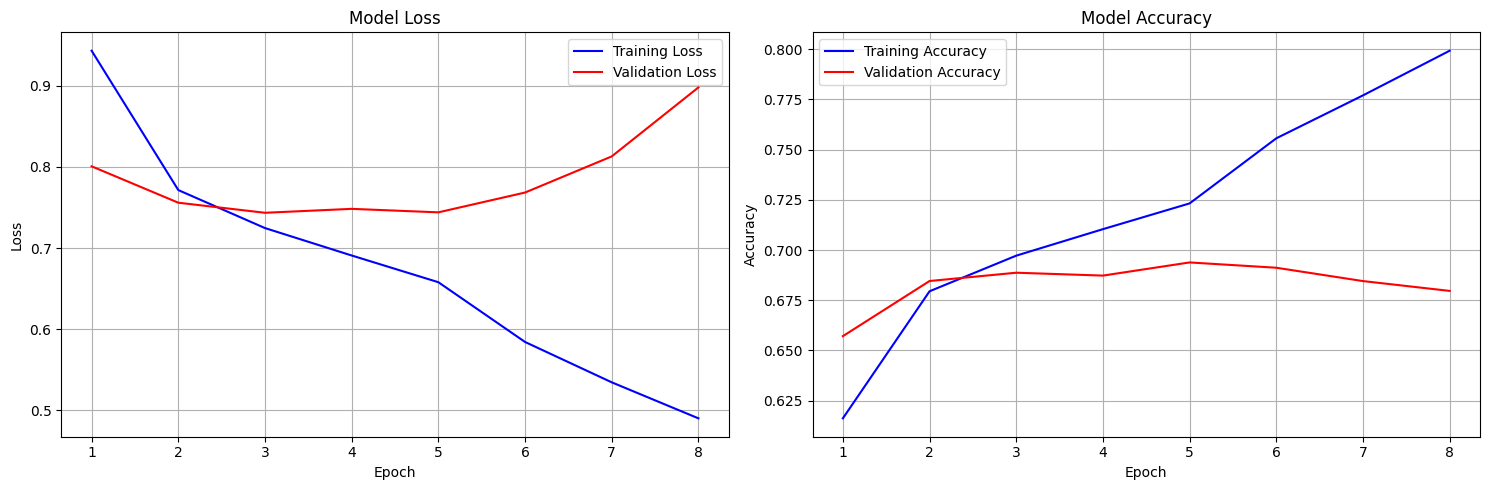

Final Training Accuracy: 0.7992
Final Validation Accuracy: 0.6797
Best Validation Accuracy: 0.6938


In [21]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

## 11. Model Evaluation on Test Set

In [22]:
# Load best model for testing
model.load_state_dict(torch.load('best_yelp_model.pth'))
print("Best model loaded for testing")

# Test the model
test_loss, test_accuracy = validate_epoch(model, test_loader, criterion, device)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Best model loaded for testing

Test Results:
Test Loss: 0.7489
Test Accuracy: 0.6899



Classification Report:
              precision    recall  f1-score   support

      1 Star       0.77      0.83      0.80      4812
     2 Stars       0.48      0.32      0.39      2459
     3 Stars       0.47      0.39      0.43      3113
     4 Stars       0.53      0.45      0.49      6567
     5 Stars       0.78      0.88      0.82     14522

    accuracy                           0.69     31473
   macro avg       0.60      0.57      0.58     31473
weighted avg       0.67      0.69      0.68     31473



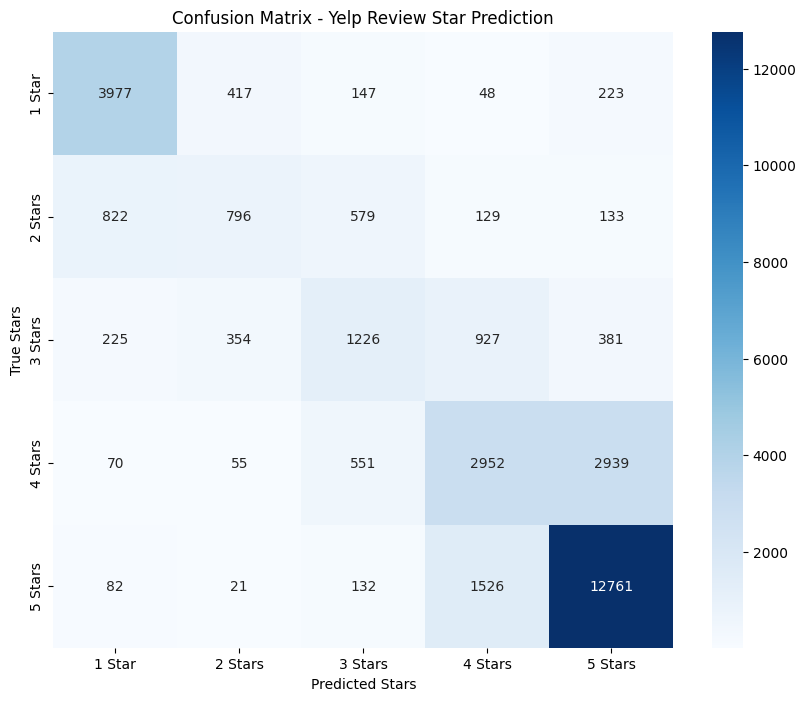

In [25]:
# Detailed evaluation with classification report and confusion matrix
def detailed_evaluation(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

# Get predictions
test_predictions, test_labels = detailed_evaluation(model, test_loader, device)

# Convert back to 1-5 star scale for interpretation
test_predictions_stars = [pred + 1 for pred in test_predictions]
test_labels_stars = [label + 1 for label in test_labels]

# Classification report
print("\nClassification Report:")
print(classification_report(
    test_labels_stars, 
    test_predictions_stars, 
    target_names=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
))

# Confusion Matrix
cm = confusion_matrix(test_labels_stars, test_predictions_stars)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
            yticklabels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'])
plt.title('Confusion Matrix - Yelp Review Star Prediction')
plt.xlabel('Predicted Stars')
plt.ylabel('True Stars')
plt.show()

## 12. Inference Function for New Reviews

In [26]:
# Function to predict star rating for new review text
def predict_stars(text, model, word_to_idx, device, max_length=200):
    """Predict star rating for a new review text"""
    model.eval()
    
    # Preprocess the text
    clean_text_input = clean_text(text)
    tokens = tokenize_text(clean_text_input)
    
    # Convert to sequence
    sequence = text_to_sequence(tokens, word_to_idx, max_length)
    
    # Convert to tensor
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(sequence_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted_class = torch.max(outputs, 1)
        
    # Convert back to 1-5 star scale
    predicted_stars = predicted_class.item() + 1
    confidence = probabilities[0][predicted_class].item()
    
    # Get probability distribution
    prob_dist = probabilities[0].cpu().numpy()
    
    return predicted_stars, confidence, prob_dist

# Test with sample reviews
test_reviews = [
    "This restaurant is absolutely amazing! The food was incredible and the service was perfect. I will definitely come back!",
    "The food was okay, nothing special. Service was a bit slow but not terrible.",
    "Worst experience ever! The food was cold, the service was rude, and the place was dirty. Never coming back!",
    "Great atmosphere and delicious food. The staff was friendly and attentive. Highly recommended!",
    "Average place. Food was decent but overpriced. Nothing to write home about."
]

print("Testing model predictions on sample reviews:")
print("=" * 80)

for i, review in enumerate(test_reviews, 1):
    predicted_stars, confidence, prob_dist = predict_stars(review, model, word_to_idx, device)
    
    print(f"\nReview {i}:")
    print(f"Text: {review}")
    print(f"Predicted Stars: {predicted_stars}")
    print(f"Confidence: {confidence:.3f}")
    print(f"Probability Distribution:")
    for j, prob in enumerate(prob_dist):
        print(f"  {j+1} stars: {prob:.3f}")
    print("-" * 40)

Testing model predictions on sample reviews:

Review 1:
Text: This restaurant is absolutely amazing! The food was incredible and the service was perfect. I will definitely come back!
Predicted Stars: 5
Confidence: 0.995
Probability Distribution:
  1 stars: 0.000
  2 stars: 0.000
  3 stars: 0.000
  4 stars: 0.005
  5 stars: 0.995
----------------------------------------

Review 2:
Text: The food was okay, nothing special. Service was a bit slow but not terrible.
Predicted Stars: 3
Confidence: 0.566
Probability Distribution:
  1 stars: 0.035
  2 stars: 0.372
  3 stars: 0.566
  4 stars: 0.027
  5 stars: 0.001
----------------------------------------

Review 3:
Text: Worst experience ever! The food was cold, the service was rude, and the place was dirty. Never coming back!
Predicted Stars: 1
Confidence: 0.994
Probability Distribution:
  1 stars: 0.994
  2 stars: 0.006
  3 stars: 0.000
  4 stars: 0.000
  5 stars: 0.000
----------------------------------------

Review 4:
Text: Great atmosphe

## 13. Model Analysis and Insights

In [28]:
# Analyze model performance by star rating
from collections import defaultdict

# Group predictions by true star rating
performance_by_star = defaultdict(list)
for true_label, prediction in zip(test_labels_stars, test_predictions_stars):
    performance_by_star[true_label].append(prediction)

print("Model Performance by Star Rating:")
print("=" * 50)

for star_rating in sorted(performance_by_star.keys()):
    predictions = performance_by_star[star_rating]
    # correct = sum(1 for pred in predictions if pred == star_rating)
    total = len(predictions)
    # accuracy = correct / total if total > 0 else 0
    
    print(f"{star_rating} Star Reviews:")
    print(f"  Total: {total}")
    # print(f"  Correct: {correct}")
    # print(f"  Accuracy: {accuracy:.3f}")
    
    # Show distribution of predictions
    pred_dist = Counter(predictions)
    print(f"  Prediction distribution: {dict(sorted(pred_dist.items()))}")
    print()

# Overall statistics
overall_accuracy = accuracy_score(test_labels_stars, test_predictions_stars)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Calculate accuracy within 1 star (close predictions)
# within_one_star = sum(1 for true, pred in zip(test_labels_stars, test_predictions_stars) 
                    #  if abs(true - pred) <= 1) / len(test_labels_stars)
# print(f"Accuracy within 1 star: {within_one_star:.4f}")

Model Performance by Star Rating:
1 Star Reviews:
  Total: 4812
  Prediction distribution: {1: 3977, 2: 417, 3: 147, 4: 48, 5: 223}

2 Star Reviews:
  Total: 2459
  Prediction distribution: {1: 822, 2: 796, 3: 579, 4: 129, 5: 133}

3 Star Reviews:
  Total: 3113
  Prediction distribution: {1: 225, 2: 354, 3: 1226, 4: 927, 5: 381}

4 Star Reviews:
  Total: 6567
  Prediction distribution: {1: 70, 2: 55, 3: 551, 4: 2952, 5: 2939}

5 Star Reviews:
  Total: 14522
  Prediction distribution: {1: 82, 2: 21, 3: 132, 4: 1526, 5: 12761}

Overall Test Accuracy: 0.6899


## 14. Save Model and Vocabulary

In [30]:
# Save model, vocabulary, and metadata for future use
import pickle

# Save vocabulary
with open('yelp_vocabulary.pkl', 'wb') as f:
    pickle.dump({
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'vocab_size': vocab_size,
        'max_sequence_length': MAX_SEQUENCE_LENGTH
    }, f)

# Save model metadata
model_metadata = {
    'model_params': {
        'vocab_size': vocab_size,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'output_dim': OUTPUT_DIM,
        'n_layers': N_LAYERS,
        'dropout': DROPOUT
    },
    'training_params': {
        'batch_size': BATCH_SIZE,
        'num_epochs': len(train_losses),
        'learning_rate': 0.001,
        'max_sequence_length': MAX_SEQUENCE_LENGTH
    },
    'performance': {
        'best_val_accuracy': best_val_accuracy,
        'test_accuracy': test_accuracy
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model artifacts saved:")
print("- best_yelp_model.pth (model weights)")
print("- yelp_vocabulary.pkl (vocabulary)")
print("- model_metadata.json (model configuration and performance)")

print(f"\nFinal Model Summary:")
print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Accuracy within 1 star: {within_one_star:.4f}")
# print(f"Total trainable parameters: {count_parameters(model):,}")

Model artifacts saved:
- best_yelp_model.pth (model weights)
- yelp_vocabulary.pkl (vocabulary)
- model_metadata.json (model configuration and performance)

Final Model Summary:
Test Accuracy: 0.6899


## Conclusion

This notebook demonstrated how to:

1. **Load and preprocess** Yelp review data from Spark/Delta tables
2. **Clean and tokenize** text data for neural network input
3. **Build vocabulary** and convert text to numerical sequences
4. **Create custom PyTorch Dataset** and DataLoader classes
5. **Define a bidirectional LSTM** neural network architecture
6. **Implement training and validation** loops with early stopping
7. **Evaluate model performance** with detailed metrics
8. **Create inference functions** for new text predictions
9. **Save the trained model** and vocabulary for future use

### Key Techniques Used:
- **Bidirectional LSTM** for capturing context in both directions
- **Word embeddings** to represent text as dense vectors
- **Dropout and gradient clipping** for regularization
- **Early stopping** to prevent overfitting
- **Learning rate scheduling** for better convergence

### Potential Improvements:
- Use pre-trained word embeddings (Word2Vec, GloVe)
- Implement attention mechanisms
- Try transformer-based models (BERT)
- Ensemble multiple models
- Add more sophisticated text preprocessing
- Use class weights to handle imbalanced data